In [1]:
import pandas as pd
exercise_data = pd.read_csv( 'exercise.csv' )
calories_data = pd.read_csv( 'calories.csv' )

In [2]:
# join both CSV files using User_ID as key and left outer join (preserve exercise_data even if there are no calories)
joined_data = exercise_data.join( calories_data.set_index( 'User_ID' ), on='User_ID', how='left')
joined_data.head()

,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,14733363,male,68,190.0,94.0,29.0,105.0,40.8,231.0
1,14861698,female,20,166.0,60.0,14.0,94.0,40.3,66.0
2,11179863,male,69,179.0,79.0,5.0,88.0,38.7,26.0
3,16180408,female,34,179.0,71.0,13.0,100.0,40.5,71.0
4,17771927,female,27,154.0,58.0,10.0,81.0,39.8,35.0


In [3]:
# in the scatter plot of duration vs calories and heart rate vs calories the relationship
# was curved upward (not linear)
# feature engineering:  add squared duration and heart rate to try a better fit with calories
joined_data = joined_data.assign( squared_duration = joined_data[ 'Duration' ] ** 2 )
joined_data = joined_data.assign( squared_heart_rate = lambda x: x[ 'Heart_Rate' ] ** 2 )

joined_data.head()

,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories,squared_duration,squared_heart_rate
0,14733363,male,68,190.0,94.0,29.0,105.0,40.8,231.0,841.0,11025.0
1,14861698,female,20,166.0,60.0,14.0,94.0,40.3,66.0,196.0,8836.0
2,11179863,male,69,179.0,79.0,5.0,88.0,38.7,26.0,25.0,7744.0
3,16180408,female,34,179.0,71.0,13.0,100.0,40.5,71.0,169.0,10000.0
4,17771927,female,27,154.0,58.0,10.0,81.0,39.8,35.0,100.0,6561.0


In [4]:
# since we don't want the prediction to be negative calories, 
# convert calories to natural logarithm to always get a positive number
import numpy as np
joined_data = joined_data.assign( log_Calories = lambda x: 
                                 np.log( x[ 'Calories' ] ) )
joined_data.head()

,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories,squared_duration,squared_heart_rate,log_Calories
0,14733363,male,68,190.0,94.0,29.0,105.0,40.8,231.0,841.0,11025.0,5.442418
1,14861698,female,20,166.0,60.0,14.0,94.0,40.3,66.0,196.0,8836.0,4.189655
2,11179863,male,69,179.0,79.0,5.0,88.0,38.7,26.0,25.0,7744.0,3.258097
3,16180408,female,34,179.0,71.0,13.0,100.0,40.5,71.0,169.0,10000.0,4.262680
4,17771927,female,27,154.0,58.0,10.0,81.0,39.8,35.0,100.0,6561.0,3.555348


In [5]:
# scale numbers with normal distribution using z-score
from scipy.stats import zscore

joined_data = joined_data.assign( zscore_body_temp = zscore( joined_data[ 'Body_Temp' ] ) )
joined_data = joined_data.assign( zscore_height = zscore( joined_data[ 'Height' ] ) )
joined_data = joined_data.assign( zscore_weight = zscore( joined_data[ 'Weight' ] ) )
joined_data = joined_data.assign( zscore_squared_heart_rate = zscore( joined_data[ 'squared_heart_rate' ] ) )

joined_data.head()

,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories,squared_duration,squared_heart_rate,log_Calories,zscore_body_temp,zscore_height,zscore_weight,zscore_squared_heart_rate
0,14733363,male,68,190.0,94.0,29.0,105.0,40.8,231.0,841.0,11025.0,5.442418,0.994023,1.089582,1.265909,0.987193
1,14861698,female,20,166.0,60.0,14.0,94.0,40.3,66.0,196.0,8836.0,4.189655,0.352342,-0.593726,-0.995458,-0.207123
2,11179863,male,69,179.0,79.0,5.0,88.0,38.7,26.0,25.0,7744.0,3.258097,-1.701035,0.318066,0.268247,-0.802917
3,16180408,female,34,179.0,71.0,13.0,100.0,40.5,71.0,169.0,10000.0,4.262680,0.609015,0.318066,-0.263839,0.427955
4,17771927,female,27,154.0,58.0,10.0,81.0,39.8,35.0,100.0,6561.0,3.555348,-0.289338,-1.435380,-1.128480,-1.448360


In [6]:
# scale non-normal columns (age, squared_duration) using Min-Max 
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# NOTE:  joined_data[ ['Age', 'squared_duration'] ] produces a copy, loc doesn't
minMaxData = pd.DataFrame( scaler.fit_transform( joined_data.loc[ :, ['Age','squared_duration'] ] )
                         , columns = [ 'minMaxAge', 'minMaxSquaredDuration' ] )
joined_data = pd.concat( [ joined_data, minMaxData ], axis = 1, join = 'inner' )


In [7]:
# what to do with Gender (string binary categorical variable)?
# convert to zero (male) and one (female)
# trick:  first convert to boolean (Gender==female) , then to int by adding 0
joined_data = joined_data.assign( numeric_gender = 0 + ( joined_data[ 'Gender' ] == 'female' ) )


In [8]:
# exclude User_ID and log_Calories from the prediction model (they're not features)
del joined_data[ 'User_ID' ]

In [9]:
ageDF = joined_data[ 'Age' ]
heartRateDF = joined_data[ 'Heart_Rate' ]

# remove unneeded columns

# remove Duration and Heart_Rate
del joined_data[ 'Duration' ]
del joined_data[ 'Heart_Rate' ]
del joined_data[ 'Calories' ]


joined_data.pop( 'Body_Temp' )
joined_data.pop( 'Height' )
joined_data.pop( 'Weight' )
joined_data.pop( 'squared_heart_rate' )
joined_data.pop( 'Age' )
joined_data.pop( 'squared_duration' )
joined_data.pop( 'Gender' )
joined_data.head()

,log_Calories,zscore_body_temp,zscore_height,zscore_weight,zscore_squared_heart_rate,minMaxAge,minMaxSquaredDuration,numeric_gender
0,5.442418,0.994023,1.089582,1.265909,0.987193,0.813559,0.934372,0
1,4.189655,0.352342,-0.593726,-0.995458,-0.207123,0.000000,0.216908,1
2,3.258097,-1.701035,0.318066,0.268247,-0.802917,0.830508,0.026696,0
3,4.262680,0.609015,0.318066,-0.263839,0.427955,0.237288,0.186874,1
4,3.555348,-0.289338,-1.435380,-1.128480,-1.448360,0.118644,0.110122,1


In [10]:
# split data into test and training

from sklearn.model_selection import train_test_split

train, test = train_test_split( joined_data, test_size = 0.3 )

In [11]:
# separate features from what we want to predict
train_target = train[ 'log_Calories' ]
train.pop( 'log_Calories' )

# create linear regression object and train the model (ordinary least squares linear regression)
from sklearn import linear_model
regr = linear_model.LinearRegression( fit_intercept = True )
regr.fit( train, train_target )

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [12]:
# separate features from what we want to test
test_target = test[ 'log_Calories' ]
del test[ 'log_Calories' ]

In [13]:
test_prediction = regr.predict( test )

# evaluate model against test data 
# coeficient of determination (r-squared is better near 1)
from sklearn.metrics import r2_score
rSquared = r2_score( test_target, test_prediction )

In [14]:
# relative absolute/squared error (it is better near zero)
from sklearn.metrics import mean_squared_error
mse = mean_squared_error( test_target, test_prediction )

In [15]:
# get ages and heart rates whose index match the test dataframe
ageDF = ageDF[ ageDF.index.isin( test.index ) ]
heartRateDF = heartRateDF[ heartRateDF.index.isin( test.index ) ]

In [16]:
# join log_Calories back into the main test dataframe
test = pd.concat( [ test, test_target ], axis = 1, join = 'inner' )

<IPython.core.display.Javascript object>


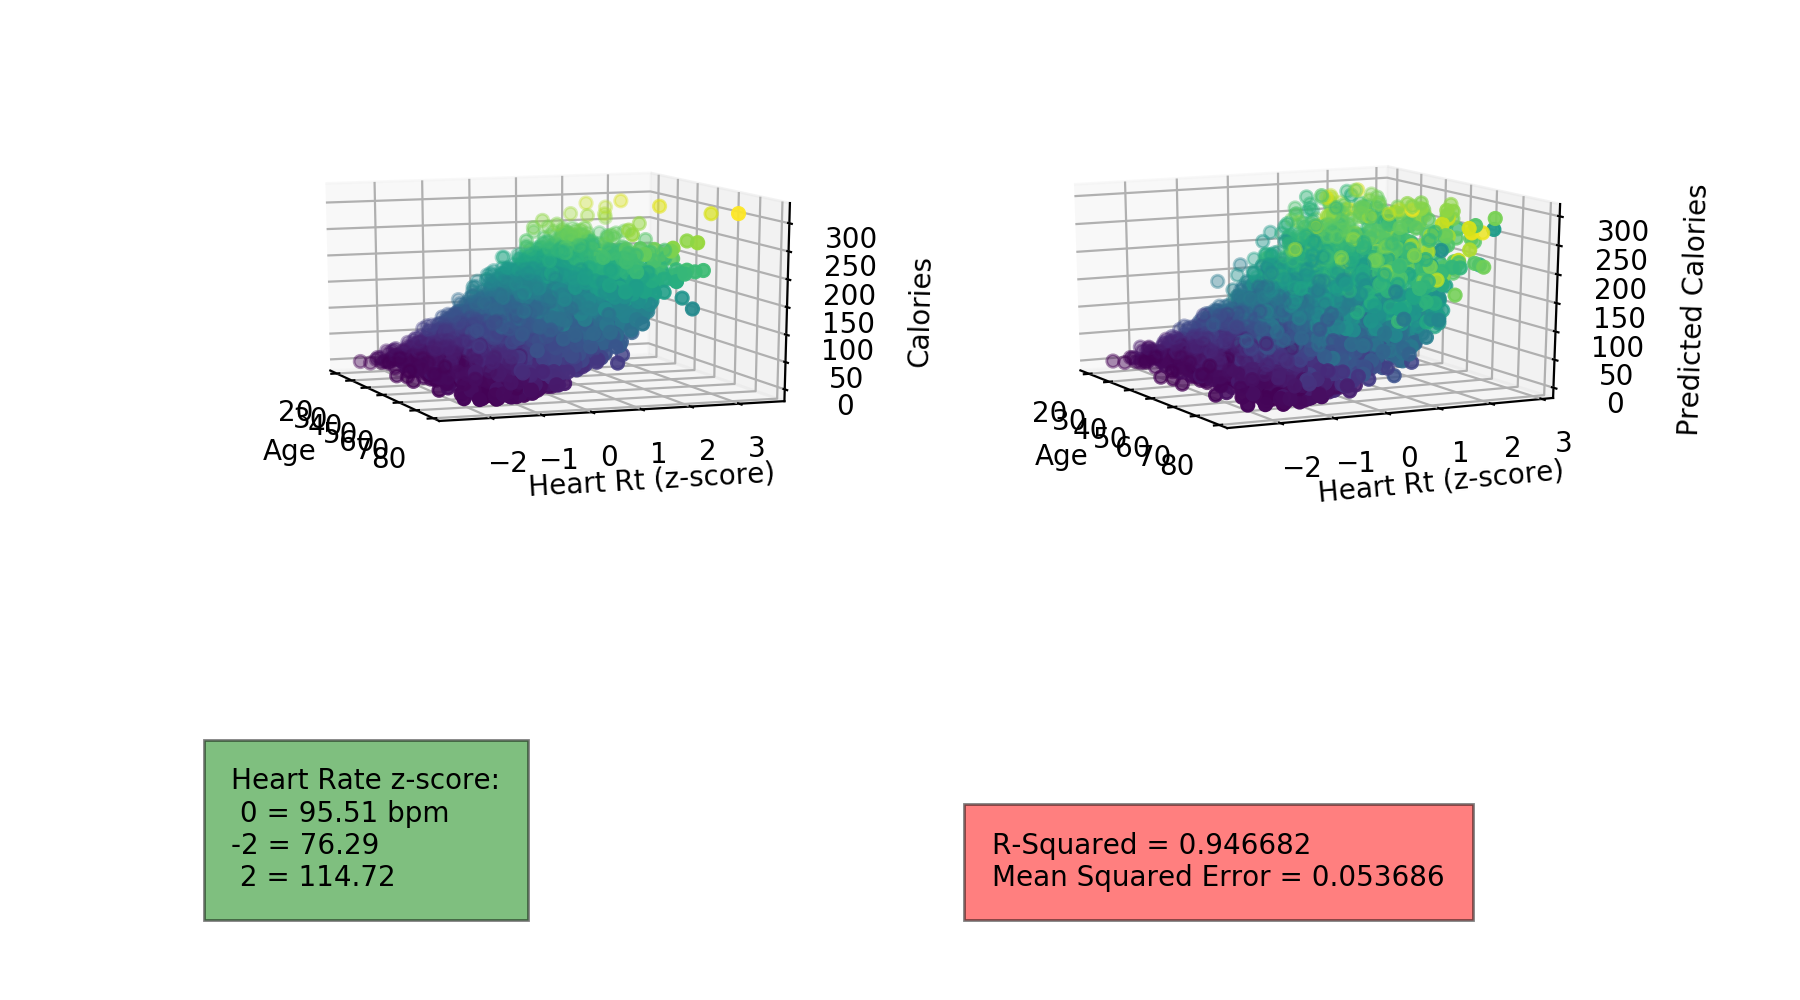

In [23]:
# create a 3d scatter plot
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
fig = plt.figure( figsize= (9,5) )

exCalPlot = fig.add_subplot( 221, projection = '3d' )

import math

# convert from log calories
testCalories = test[ 'log_Calories' ].apply( float ).apply( math.exp )

exCalPlot.scatter3D( ageDF
                         , test[ 'zscore_squared_heart_rate' ]
                         , testCalories.astype(int)
                         , c = testCalories )

exCalPlot.set_xlabel( 'Age' )
exCalPlot.set_ylabel( 'Heart Rt (z-score)' )
exCalPlot.set_zlabel( 'Calories' )

predCalPlot = fig.add_subplot( 222, projection = '3d' )

# convert from log calories
predCalories = [ math.exp( float( x ) ) for x in test_prediction ]
# clip graph at 300 calories
predCalories = [ ( x if x < 300 else float('nan') ) for x in predCalories ]

predCalPlot.scatter3D( ageDF
                         , test[ 'zscore_squared_heart_rate' ]
                         , predCalories
                         , c = testCalories )

predCalPlot.set_xlabel( 'Age' )
predCalPlot.set_ylabel( 'Heart Rt (z-score)' )
predCalPlot.set_zlabel( 'Predicted Calories' )

# add text
hrMean = heartRateDF.mean()
hrStdMinus2 = hrMean - heartRateDF.std() * 2
hrStdPlus2 = hrMean + heartRateDF.std() * 2
explanation = "Heart Rate z-score:\n 0 = %.2f bpm \n-2 = %.2f \n 2 = %.2f" % ( hrMean, hrStdMinus2, hrStdPlus2 )
explanPlot = fig.add_subplot(223)
explanPlot.text( 0.01, 0.01, explanation
        , bbox={'facecolor':'green', 'alpha':0.5, 'pad':10} )
explanPlot.set_axis_off()

# add text
precisionText = "R-Squared = %.6f \nMean Squared Error = %.6f" % ( rSquared, mse )
precPlot = fig.add_subplot(224)
precPlot.text( 0.01, 0.01, precisionText
        , bbox={'facecolor':'red', 'alpha':0.5, 'pad':10} )
precPlot.set_axis_off()

# rotate the axes and update
for angle in range( 0, 360, 5 ):
    exCalPlot.view_init( 30, angle )
    predCalPlot.view_init( 30, angle )
    plt.draw()
    plt.pause( .001 )

#plt.show()